In [1]:
import cv2, time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import math

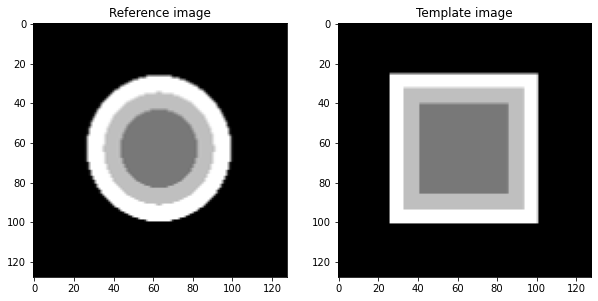

In [2]:
ref_img = cv2.imread('./Images/R1.png',32)
temp_img = cv2.imread('./Images/T1.png',32)
#temp_img = cv2.imread('./Images/t2_T.png',32)
#ref_img = cv2.imread('./Images/t2_R.png',32)
shape = min(min(ref_img.shape),min(temp_img.shape))//16*16
img_shape = (shape,shape)
ref_img = cv2.resize(ref_img,img_shape,interpolation=cv2.INTER_CUBIC)
temp_img = cv2.resize(temp_img,img_shape,interpolation=cv2.INTER_CUBIC)

# from 0-255 to 0-1
ref_img = np.float32((ref_img-np.min(ref_img))/(np.max(ref_img)-np.min(ref_img)))
temp_img = np.float32((temp_img-np.min(temp_img))/(np.max(temp_img)-np.min(temp_img)))

figure = plt.figure(figsize=(10,5))
figure.add_subplot(1,2,1)
plt.title('Reference image')
plt.imshow(ref_img,cmap='gray')
figure.add_subplot(1,2,2)
plt.title('Template image')
plt.imshow(temp_img,cmap='gray')
plt.show()

# Setup functions and model

In [3]:
# Dense image warp from Tensorflow addons
# There is an error using tfa.image.dense_image_warp
# define same tfa.image.dense_image_warp

from tensorflow_addons.utils import types
from typing import Optional

def _get_dim(x, idx):
    if x.shape.ndims is None:
        return tf.shape(x)[idx]
    return x.shape[idx] or tf.shape(x)[idx]

def dense_image_warp(
    image: types.TensorLike, flow: types.TensorLike, name: Optional[str] = None
) -> tf.Tensor:
    with tf.name_scope(name or "dense_image_warp"):
        image = tf.convert_to_tensor(image)
        flow = tf.convert_to_tensor(flow)
        batch_size, height, width, channels = (
            _get_dim(image, 0),
            _get_dim(image, 1),
            _get_dim(image, 2),
            _get_dim(image, 3),
        )

        # The flow is defined on the image grid. Turn the flow into a list of query
        # points in the grid space.
        grid_x, grid_y = tf.meshgrid(tf.range(width), tf.range(height))
        stacked_grid = tf.cast(tf.stack([grid_y, grid_x], axis=2), flow.dtype)
        batched_grid = tf.expand_dims(stacked_grid, axis=0)
        query_points_on_grid = batched_grid - flow
        query_points_flattened = tf.reshape(query_points_on_grid, [batch_size, height * width, 2])
        # Compute values at the query points, then reshape the result back to the
        # image grid.
        interpolated = tfa.image.interpolate_bilinear(image, query_points_flattened)
        interpolated = tf.reshape(interpolated, [batch_size, height, width, channels])
        return interpolated

In [4]:
def img_grad(img):
    # Image gradient by central difference
    dx = tf.pad((img[2:,:]-img[:-2,:])/2,paddings=([[1,1],[0,0]]))
    dy = tf.pad((img[:,2:]-img[:,:-2])/2,paddings=([[0,0],[1,1]]))
    return tf.stack([dx, dy], axis=0)

def exp_vec_field(vec_field,update_step_length):
    small_vec = 1*vec_field
    max_length_vec = tf.reduce_max(tf.norm(small_vec,axis=0))
    N = 0
    while max_length_vec>update_step_length:
        small_vec /= 2
        max_length_vec = tf.reduce_max(tf.norm(small_vec,axis=0))
        N+=1
    flow = tf.expand_dims(tf.transpose(small_vec,[1,2,0]),axis=0) #(1,img_shape[0],img_shape[1],2)
    for _ in range(N):
        flow += dense_image_warp(flow,-flow) #(1,img_shape[0],img_shape[1],2)
    return tf.transpose(flow[0],[2,0,1])

In [5]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=img_shape+(3,))

layer_names = ['block1_conv2','block2_conv2','block3_conv3','block4_conv3','block5_conv3']
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,name='down_stack')
down_stack.trainable = False

inputs = tf.keras.layers.Input(shape=img_shape+(3,))
# Downsampling through the model
skips = down_stack(inputs)
x = skips.pop()
skips = skips[::-1]
# Upsampling and establishing the skip connections
up = tf.keras.layers.UpSampling2D(2)

for skip in skips:
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(x.shape[3]/4,3,activation='relu',padding='same')(x)
x = tf.keras.layers.Conv2D(1,3,padding='same',activation='tanh',kernel_initializer='zeros',bias_initializer='zeros')(x)

heatmap_model = tf.keras.Model(inputs=inputs, outputs=x,name='heatmap_model')
heatmap_model.summary()
Wsave = heatmap_model.get_weights()

Model: "heatmap_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
down_stack (Functional)         [(None, 128, 128, 64 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    multiple             0           down_stack[0][4]                 
                                                                 conv2d[0][0]                     
                                                                 conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]       

In [6]:
def hm_fn(h,step_t=1e-5,dc_eps=1e-2):
    t = 0
    step_new = step_t
    amp = 2
    while True:   
        hm = tf.clip_by_value(h+t,-np.inf,0)+tf.clip_by_value(h-t,0,np.inf)
        diff_cost = abs(tf.reduce_sum((ref_img+hm-warped_img_s)**2)-tf.reduce_sum((ref_img-warped_img_s)**2))
        if diff_cost<dc_eps :
            if step_new==step_t:
                break
            t = t_old
            step_new/=amp
            t+=step_new
        else:
            t_old = t
            step_new*=amp
            t+=step_new
    return hm

# Diffeomorphic demons

In [7]:
def diff_dem(ref_img,
             temp_img,Imax=1000,
             rel_ssd_eps=5e-2,
             rel_diff_eps=1e-4,
             displacement_field = np.zeros((shape,shape,2)),
             fluid_sigma = 1.0,
             diffusion_sigma = 1.0,
             update_step_length = 0.5,
             beta = 1e-6):
    
    expand_dim_temp_img = tf.expand_dims(tf.expand_dims(temp_img,0),-1) # shape (batch=1,img_shape[0],img_shape[1],channel=1)
    warped_img = tf.squeeze(dense_image_warp(expand_dim_temp_img,tf.expand_dims(displacement_field,0)))
    diff_intensity = tf.subtract(ref_img,warped_img)
    ssd0 = tf.reduce_sum(diff_intensity**2)/2
    rel_ssds = tf.constant([1.])
    for i in range(Imax):
        displacement_field_old = 1*displacement_field
        # compute the update fields
        J = img_grad(warped_img) #moving demon force of shape (2,img_shape[0],img_shape[1])
        update_fields = -((diff_intensity*J)/(tf.norm(J,axis=0)**2+diff_intensity**2+beta)) #shape (2,img_shape[0],img_shape[1])
        # fluid-like regularization
        update_field_x = tfa.image.gaussian_filter2d(update_fields[0],padding="SYMMETRIC",sigma=fluid_sigma)
        update_field_y = tfa.image.gaussian_filter2d(update_fields[1],padding="SYMMETRIC",sigma=fluid_sigma)
        update_fields = tf.stack([update_field_x,update_field_y],0) #shape (2,img_shape[0],img_shape[1])
        # update the correspondence fields by diffeomorphic type
        exp_update_fields = exp_vec_field(update_fields,update_step_length) #(2,img_shape[0],img_shape[1])
        dis_warp = dense_image_warp(tf.expand_dims(displacement_field,0),-tf.expand_dims(tf.transpose(exp_update_fields,[1,2,0]),0)) #(1,img_shape[0],img_shape[1],2)
        dis_warp = tf.cast(dis_warp,tf.float32)
        corres_fields = tf.math.add(exp_update_fields,tf.transpose(dis_warp[0],[2,0,1])) #(2,img_shape[0],img_shape[1])
        # diffusion-like regularization
        corres_field_x = tfa.image.gaussian_filter2d(corres_fields[0],padding="SYMMETRIC",sigma=diffusion_sigma)
        corres_field_y = tfa.image.gaussian_filter2d(corres_fields[1],padding="SYMMETRIC",sigma=diffusion_sigma)
        displacement_field = tf.stack([corres_field_x,corres_field_y],-1) #shape (img_shape[0],img_shape[1],2)

        warped_img = tf.squeeze(dense_image_warp(expand_dim_temp_img,tf.expand_dims(displacement_field,0)))
        
        rel_diff_disp_field = tf.norm(displacement_field-displacement_field_old)/(tf.norm(displacement_field)+beta)
        
        diff_intensity = tf.subtract(ref_img,warped_img)
        ssd = tf.reduce_sum(diff_intensity**2)/2
        rel_ssd = ssd/ssd0
        if rel_diff_disp_field<rel_diff_eps:
            break
        if rel_ssd<rel_ssd_eps:
            break
    return warped_img, displacement_field

# Deep Diffeomorphic Registration

In [8]:
warped_img_start, T_start = diff_dem(ref_img,temp_img,0)
update_h = 50
update_T = update_h*1
swicth_h_n_T = 40

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [9]:
'''heatmap_model.set_weights(Wsave) #reinitailize all weights

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7)

warped_img_s,T_s = warped_img_start,T_start
hms = 0*ref_img
ssd = tf.reduce_sum((ref_img-warped_img_s)**2)
SSDs1 = [[ssd,ssd]]

warped_img_s,T_s = diff_dem(ref_img,temp_img,update_T,displacement_field=T_s)
for j in range(swicth_h_n_T):
    warped_img_s,T_s = diff_dem(ref_img+hms,temp_img,update_T,displacement_field=T_s)
    for _ in range(update_h):
        with tf.GradientTape() as tape:
            input_img = tf.expand_dims(tf.tile(tf.expand_dims(ref_img,-1),(1,1,3)),0)
            h = tf.squeeze(heatmap_model(input_img))
            hms = hm_fn(h,step_t=1e-5,dc_eps=1e-1)
            loss_value = tf.reduce_sum((ref_img+hms-warped_img_s)**2)
            print(np.max(abs(hms)),'\t',float(loss_value))
        grads = tape.gradient(loss_value, heatmap_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, heatmap_model.trainable_weights))
    
    print(j+1)
    SSDs1.append([tf.reduce_sum((ref_img-warped_img_s)**2),loss_value])
    
    
    
SSDs1 = np.array(SSDs1)
SSD1 = np.transpose(SSDs1)'''
print()

0.0 	 521.7230224609375
0.13166559 	 521.822998046875
0.09180635 	 521.623046875
0.08635646 	 521.623046875
0.08203268 	 521.623046875
0.078332424 	 521.6231079101562
0.075665414 	 521.623046875
0.07399672 	 521.623046875
0.07267475 	 521.623046875
0.07155144 	 521.6231079101562
0.070121884 	 521.623046875
0.068733096 	 521.623046875
0.06751102 	 521.623046875
0.066408634 	 521.623046875
0.06536305 	 521.623046875
0.0643003 	 521.623046875
0.06295127 	 521.623046875
0.06117779 	 521.623046875
0.058535635 	 521.623046875
0.056452394 	 521.623046875
0.055279136 	 521.623046875
0.054611504 	 521.623046875
0.05412376 	 521.623046875
0.053588867 	 521.623046875
0.05306536 	 521.623046875
0.05252695 	 521.623046875
0.052019 	 521.623046875
0.051629364 	 521.623046875
0.051282167 	 521.623046875
0.050952196 	 521.623046875
0.0506292 	 521.623046875
0.050329983 	 521.623046875
0.0500347 	 521.623046875
0.04975277 	 521.623046875
0.049458265 	 521.623046875
0.049176455 	 521.623046875
0.0488359

0.0340693 	 80.42814636230469
0.034018636 	 80.42819213867188
0.03398621 	 80.42813873291016
0.033941507 	 80.42816925048828
0.033895373 	 80.4281997680664
0.033857226 	 80.42818450927734
0.03381741 	 80.42818450927734
0.03377533 	 80.42819213867188
0.033741713 	 80.42815399169922
0.033696294 	 80.42818450927734
0.03365892 	 80.42816925048828
0.03362 	 80.42816162109375
0.03357923 	 80.42817687988281
0.033536613 	 80.42819213867188
0.03350234 	 80.42816162109375
0.03346622 	 80.42814636230469
0.03342843 	 80.42813873291016
0.03338909 	 80.42814636230469
0.033347905 	 80.42815399169922
0.033305287 	 80.42817687988281
0.033270597 	 80.42815399169922
0.033234656 	 80.42813873291016
0.033197045 	 80.42814636230469
0.033157587 	 80.42814636230469
0.033116758 	 80.42816925048828
0.033084214 	 80.42813873291016
0.033040106 	 80.42817687988281
0.033004582 	 80.42817687988281
0.03296733 	 80.42816925048828
0.032928884 	 80.42817687988281
0.032898545 	 80.42813873291016
0.032856822 	 80.42816162

0.035559595 	 27.597408294677734
0.035514534 	 27.597393035888672
0.035469294 	 27.59737777709961
0.0354138 	 27.597421646118164
0.035368204 	 27.597412109375
0.03532225 	 27.59740447998047
0.035276115 	 27.597400665283203
0.035229623 	 27.597396850585938
0.03518313 	 27.597396850585938
0.035136342 	 27.597396850585938
0.035089314 	 27.597400665283203
0.035042107 	 27.59740447998047
0.03499466 	 27.597414016723633
0.034947038 	 27.597423553466797
0.03490919 	 27.597381591796875
0.034861207 	 27.597394943237305
0.034812927 	 27.597408294677734
0.03476441 	 27.597427368164062
0.034725785 	 27.597393035888672
0.03467697 	 27.597412109375
0.03463787 	 27.597381591796875
0.034579396 	 27.59738540649414
0.034520745 	 27.597400665283203
0.034458876 	 27.597436904907227
0.0344069 	 27.59740447998047
0.03435445 	 27.59737777709961
10
0.02722156 	 26.98687744140625
0.027195215 	 26.98689079284668
0.027168453 	 26.98690414428711
0.02714628 	 26.986875534057617
0.02712363 	 26.986846923828125
0.02

0.024718761 	 24.40658187866211
0.02468878 	 24.406566619873047
0.02465874 	 24.406558990478516
0.024618506 	 24.406648635864258
0.02458793 	 24.40664291381836
0.024557233 	 24.406641006469727
0.024526238 	 24.406644821166992
0.024494886 	 24.406648635864258
0.024473608 	 24.406558990478516
0.024441838 	 24.406570434570312
0.024410129 	 24.406585693359375
0.024378061 	 24.406604766845703
0.024345696 	 24.40662384033203
0.02431339 	 24.40665054321289
0.02429074 	 24.406579971313477
0.02425772 	 24.4066104888916
0.024224699 	 24.40664291381836
0.024201393 	 24.40658187866211
0.024168015 	 24.40662384033203
0.024144232 	 24.40656280517578
0.024112463 	 24.406566619873047
0.024080575 	 24.406574249267578
15
0.024368405 	 24.103361129760742
0.024334848 	 24.103384017944336
0.024301112 	 24.103412628173828
0.02427733 	 24.10334014892578
0.024243236 	 24.103374481201172
0.024208903 	 24.103408813476562
0.024184287 	 24.103351593017578
0.024149716 	 24.1033935546875
0.024124801 	 24.1033420562

0.019576132 	 23.855104446411133
0.019563437 	 23.855073928833008
0.019540668 	 23.855146408081055
0.019527853 	 23.855119705200195
0.019515216 	 23.855091094970703
0.019502103 	 23.855064392089844
0.019479156 	 23.855140686035156
0.019465983 	 23.855117797851562
0.01945287 	 23.855098724365234
0.019439638 	 23.855073928833008
0.019426465 	 23.855052947998047
0.01940322 	 23.85513687133789
0.01938963 	 23.855117797851562
0.019376278 	 23.8551025390625
0.019362688 	 23.855087280273438
0.019349039 	 23.855072021484375
0.01933539 	 23.855058670043945
0.019311607 	 23.855148315429688
20
0.019777715 	 23.731769561767578
0.019754171 	 23.73185157775879
0.019740582 	 23.731836318969727
0.019726872 	 23.731821060180664
0.019713223 	 23.731809616088867
0.019699335 	 23.731796264648438
0.019685507 	 23.73178482055664
0.01967144 	 23.731775283813477
0.019656658 	 23.73177719116211
0.019641578 	 23.731781005859375
0.019626439 	 23.731782913208008
0.019611478 	 23.731788635253906
0.019596219 	 23.7

0.016995072 	 23.362701416015625
0.016982734 	 23.362716674804688
0.016970336 	 23.36273193359375
0.016957879 	 23.362749099731445
0.016945243 	 23.362770080566406
0.016932487 	 23.36279296875
0.016929686 	 23.362703323364258
0.016916811 	 23.36272621154785
0.016904056 	 23.36275291442871
0.016891062 	 23.36277961730957
0.01688832 	 23.36269187927246
0.016875207 	 23.36271858215332
0.016862154 	 23.362749099731445
0.0168491 	 23.362773895263672
0.016846001 	 23.362689971923828
0.016832888 	 23.362720489501953
25
0.016919732 	 23.265499114990234
0.016906142 	 23.26553726196289
0.016902447 	 23.265466690063477
0.016888738 	 23.265506744384766
0.016884983 	 23.265438079833984
0.016871214 	 23.26548194885254
0.016857386 	 23.265525817871094
0.016853392 	 23.265457153320312
0.016839623 	 23.2655029296875
0.01683569 	 23.265438079833984
0.016821623 	 23.265483856201172
0.016807675 	 23.26552963256836
0.016803622 	 23.265464782714844
0.016789675 	 23.265512466430664
0.016785383 	 23.265449523

0.015244424 	 23.030147552490234
0.015234768 	 23.030176162719727
0.015224993 	 23.030208587646484
0.015215278 	 23.03023910522461
0.0152154565 	 23.03015899658203
0.015205562 	 23.030189514160156
0.015195668 	 23.030221939086914
0.015195847 	 23.03014373779297
0.015185952 	 23.030176162719727
0.015176058 	 23.030208587646484
0.015166163 	 23.03023910522461
0.015166163 	 23.03016471862793
0.0151562095 	 23.030197143554688
0.015146196 	 23.03023338317871
30
0.015136123 	 22.995126724243164
0.015126169 	 22.995159149169922
0.015116274 	 22.99519157409668
0.015116334 	 22.995113372802734
0.01510632 	 22.995149612426758
0.015096247 	 22.99518394470215
0.015096188 	 22.995105743408203
0.015086234 	 22.995141983032227
0.015076041 	 22.99517822265625
0.015076041 	 22.995098114013672
0.015065849 	 22.99513816833496
0.015055716 	 22.995174407958984
0.015055597 	 22.995100021362305
0.015045345 	 22.995136260986328
0.015035272 	 22.995174407958984
0.015035033 	 22.995101928710938
0.015024781 	 22

0.013925374 	 22.89760398864746
0.013922334 	 22.897581100463867
0.013919234 	 22.897558212280273
0.013916194 	 22.89753532409668
0.013903141 	 22.897628784179688
0.013900042 	 22.89760971069336
0.013896942 	 22.897586822509766
0.013893783 	 22.897565841674805
0.013890624 	 22.897544860839844
0.013887405 	 22.89752197265625
0.013874292 	 22.89761734008789
0.013871133 	 22.89759635925293
35
0.013957858 	 22.87211036682129
0.013945043 	 22.872196197509766
0.013942003 	 22.87217140197754
0.013938904 	 22.872142791748047
0.013935864 	 22.872116088867188
0.0139327645 	 22.872089385986328
0.013919771 	 22.872177124023438
0.013916731 	 22.872150421142578
0.013913691 	 22.87212562561035
0.013910651 	 22.872100830078125
0.013897419 	 22.872188568115234
0.0138943195 	 22.872161865234375
0.0138911605 	 22.87213897705078
0.01388818 	 22.872112274169922
0.013885021 	 22.872085571289062
0.013871849 	 22.87217903137207
0.013868749 	 22.872154235839844
0.0138655305 	 22.87213134765625
0.013862312 	 22

In [10]:
heatmap_model.set_weights(Wsave) #reinitailize all weights

lr = 1e-7
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

warped_img,T = warped_img_start, T_start
warped_img_m = warped_img
Tm = T

m = tf.reduce_sum((ref_img-warped_img)**2)
SSDs = [[m,m]]

for j in range(swicth_h_n_T):
    Th = Tm
    c=m
    for _ in range(update_h):
        with tf.GradientTape() as tape:
            input_img = tf.expand_dims(tf.tile(tf.expand_dims(ref_img,-1),(1,1,3)),0)
            hm = tf.squeeze(heatmap_model(input_img))
            warped_img_n,Th = diff_dem(ref_img+hm,temp_img,update_T//update_h,displacement_field=Th)
            loss_value = tf.reduce_sum((ref_img-warped_img_n)**2)
            if np.max(hm)-np.min(hm)>0.5 or np.max(abs(hm))>0.5:
                lr/=10**(2/update_h)
                heatmap_model.set_weights(Wsave)
                optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
            print(np.max(abs(hm)),'\t',float(loss_value),'\t',lr)
        grads = tape.gradient(loss_value, heatmap_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, heatmap_model.trainable_weights))
        if m>loss_value:
            print('save')
            lr*=10**(4/swicth_h_n_T/update_h)
            #optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
            hmm = hm
            Tm = Th
            warped_img_m = warped_img_n
            m = loss_value
    if m==c:
        lr/=10**(2/swicth_h_n_T)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    print(1+j)
    warped_img, T = diff_dem(ref_img,temp_img,update_T,displacement_field=T)
    cost = tf.reduce_sum((ref_img-warped_img)**2)
    
    T_h = Tm
    warped_img_h = warped_img_m
    SSDs.append([cost,m])
    
    
    #if tf.reduce_sum((ref_img-warped_img)**2)/tf.reduce_sum((ref_img)**2)<1e-3:
        #break
SSDs = np.array(SSDs)
SSD = np.transpose(SSDs)

0.0 	 1317.423828125 	 1e-07
save
0.032686576 	 1238.95068359375 	 1.0046157902783951e-07
save
0.14775918 	 1169.74609375 	 1.0092528860766845e-07
save
0.20057595 	 1121.4482421875 	 1.0139113857366796e-07
save
0.21206807 	 1097.865966796875 	 1.0185913880541172e-07
save
0.20345393 	 1087.7689208984375 	 1.0232929922807544e-07
save
0.18793549 	 1077.5400390625 	 1.0280162981264738e-07
save
0.17954205 	 1062.27880859375 	 1.0327614057613978e-07
save
0.1758516 	 1036.880126953125 	 1.037528415818013e-07
save
0.18645157 	 1009.1119384765625 	 1.0423174293933046e-07
save
0.18467547 	 982.0419921875 	 1.0471285480509e-07
save
0.17627361 	 956.89404296875 	 1.0519618738232234e-07
save
0.15896398 	 934.3890380859375 	 1.056817509213659e-07
save
0.14730185 	 915.3607788085938 	 1.0616955571987253e-07
save
0.12992623 	 898.178466796875 	 1.0665961212302586e-07
save
0.12288538 	 884.6778564453125 	 1.0715193052376072e-07
save
0.10328614 	 872.736328125 	 1.0764652136298358e-07
save
0.08885608 	 

0.11593402 	 389.47760009765625 	 1.8706821403658166e-07
save
0.11412432 	 387.17901611328125 	 1.8793168168032847e-07
save
0.11635687 	 384.984619140625 	 1.88799134909631e-07
save
0.11170574 	 382.62347412109375 	 1.896705921211163e-07
save
0.1142516 	 380.38836669921875 	 1.9054607179632642e-07
save
0.116453804 	 378.142822265625 	 1.914255925021103e-07
save
0.112437524 	 375.9900207519531 	 1.9230917289101756e-07
save
0.11587433 	 374.00634765625 	 1.9319683170169414e-07
save
0.11342409 	 371.9586181640625 	 1.9408858775927956e-07
save
0.11520618 	 369.956787109375 	 1.949844599758063e-07
save
0.10690596 	 368.05438232421875 	 1.9588446735060076e-07
save
0.12470768 	 366.0387268066406 	 1.967886289706863e-07
save
0.11331689 	 363.7298278808594 	 1.976969640111879e-07
save
3
0.12158221 	 361.7034606933594 	 1.98609491735739e-07
save
0.11126724 	 359.4551696777344 	 1.9952623149688983e-07
save
0.12648158 	 357.5826416015625 	 2.00447202736518e-07
save
0.10637916 	 355.3526611328125 	

0.17401424 	 110.63316345214844 	 3.499451670283631e-07
save
0.2001099 	 108.97415161132812 	 3.51560440528304e-07
save
0.17321974 	 107.35330963134766 	 3.531831697919629e-07
save
0.19422969 	 105.84400939941406 	 3.5481338923358146e-07
save
0.17365924 	 104.32537078857422 	 3.564511334262503e-07
save
0.19203836 	 102.85737609863281 	 3.5809643710264213e-07
save
0.17156777 	 101.43098449707031 	 3.5974933515574845e-07
save
0.19177435 	 100.09518432617188 	 3.614098626396195e-07
save
0.17036805 	 98.72622680664062 	 3.630780547701076e-07
save
0.19191568 	 97.37741088867188 	 3.647539469256141e-07
save
0.17332233 	 95.94685363769531 	 3.6643757464783963e-07
save
0.19177996 	 94.58696746826172 	 3.6812897364253784e-07
save
0.1731644 	 93.30217742919922 	 3.6982817978027265e-07
save
0.19202809 	 92.04302978515625 	 3.7153522909717904e-07
save
0.17343391 	 90.8796157836914 	 3.7325015779572713e-07
save
0.19355187 	 89.71554565429688 	 3.749730022454901e-07
save
0.17316239 	 88.592483520507

0.24817815 	 27.323078155517578 	 6.137620051648098e-07
save
0.23246285 	 26.910999298095703 	 6.165950018614979e-07
save
0.22848648 	 26.666095733642578 	 6.194410750767973e-07
save
0.24828926 	 26.529659271240234 	 6.223002851691754e-07
save
0.25668097 	 26.47647476196289 	 6.251726927757019e-07
save
0.26065835 	 26.158769607543945 	 6.280583588133341e-07
save
0.27035543 	 26.302385330200195 	 6.309573444802095e-07
0.2645319 	 25.631488800048828 	 6.309573444802095e-07
save
0.25632843 	 25.594234466552734 	 6.338697112569433e-07
save
0.26908547 	 25.440345764160156 	 6.367955209079323e-07
save
0.2719601 	 25.566781997680664 	 6.397348354826647e-07
0.2727778 	 25.055402755737305 	 6.397348354826647e-07
save
0.2649061 	 25.11080551147461 	 6.426877173170364e-07
0.266593 	 24.626901626586914 	 6.426877173170364e-07
save
0.2495801 	 24.529640197753906 	 6.456542290346723e-07
save
0.2712557 	 24.622817993164062 	 6.486344335482553e-07
0.27567467 	 24.67620849609375 	 6.486344335482553e-07

0.08974319 	 27.167707443237305 	 4.2072662838445585e-07
0.24847886 	 35.11675262451172 	 4.2072662838445585e-07
0.100191064 	 30.2276611328125 	 4.2072662838445585e-07
0.46649104 	 36.5400505065918 	 4.2072662838445585e-07
0.44621554 	 55.073143005371094 	 4.2072662838445585e-07
0.3098221 	 59.193058013916016 	 4.2072662838445585e-07
0.15565164 	 35.37505340576172 	 4.2072662838445585e-07
0.20257771 	 39.21476364135742 	 4.2072662838445585e-07
0.20014854 	 36.236724853515625 	 4.2072662838445585e-07
0.08517786 	 30.4401912689209 	 4.2072662838445585e-07
0.18503383 	 37.48970031738281 	 4.2072662838445585e-07
0.23010673 	 36.09135437011719 	 4.2072662838445585e-07
0.109497815 	 36.70030975341797 	 4.2072662838445585e-07
0.36954802 	 36.55458450317383 	 4.2072662838445585e-07
0.3369469 	 55.52690887451172 	 4.2072662838445585e-07
0.14591517 	 39.326908111572266 	 4.2072662838445585e-07
0.3932607 	 40.39484405517578 	 4.2072662838445585e-07
0.34845588 	 54.03660583496094 	 4.207266283844

0.1839086 	 21.227710723876953 	 3.5645113342625453e-07
save
0.19423176 	 21.313671112060547 	 3.5809643710264637e-07
0.18252867 	 21.069278717041016 	 3.5809643710264637e-07
save
0.17891075 	 21.000080108642578 	 3.5974933515575273e-07
save
0.1917894 	 21.45807456970215 	 3.614098626396238e-07
0.21443187 	 21.640972137451172 	 3.614098626396238e-07
0.19347666 	 21.228591918945312 	 3.614098626396238e-07
0.19562626 	 21.200254440307617 	 3.614098626396238e-07
0.18644033 	 20.98379898071289 	 3.614098626396238e-07
save
0.18873282 	 21.009258270263672 	 3.630780547701119e-07
0.18403283 	 20.88043975830078 	 3.630780547701119e-07
save
0.18575521 	 20.941303253173828 	 3.6475394692561844e-07
0.19405895 	 21.20307731628418 	 3.6475394692561844e-07
0.20831245 	 21.249305725097656 	 3.6475394692561844e-07
0.18539268 	 20.731666564941406 	 3.6475394692561844e-07
save
0.18415086 	 20.7899227142334 	 3.6643757464784397e-07
0.20051634 	 21.395538330078125 	 3.6643757464784397e-07
0.21313575 	 21.

0.20767207 	 19.832721710205078 	 3.926449353996117e-07
0.23684728 	 20.5749454498291 	 3.926449353996117e-07
0.22395292 	 20.25165367126465 	 3.926449353996117e-07
0.22754893 	 20.12021255493164 	 3.926449353996117e-07
0.20492165 	 19.58013153076172 	 3.926449353996117e-07
0.2002256 	 19.599454879760742 	 3.926449353996117e-07
0.2147869 	 19.91055679321289 	 3.926449353996117e-07
0.22627123 	 19.989112854003906 	 3.926449353996117e-07
0.21640728 	 19.732881546020508 	 3.926449353996117e-07
0.21912217 	 19.80082893371582 	 3.926449353996117e-07
0.20796959 	 19.40809440612793 	 3.926449353996117e-07
0.20225635 	 19.457313537597656 	 3.926449353996117e-07
0.2112403 	 19.513301849365234 	 3.926449353996117e-07
0.224052 	 19.824975967407227 	 3.926449353996117e-07
0.21179394 	 19.43736457824707 	 3.926449353996117e-07
0.21036145 	 19.571533203125 	 3.926449353996117e-07
0.21463187 	 19.54787254333496 	 3.926449353996117e-07
0.21026622 	 19.432729721069336 	 3.926449353996117e-07
0.20804168

0.22351679 	 16.237863540649414 	 4.487453899331464e-07
save
0.19794784 	 16.167783737182617 	 4.5081670454147446e-07
save
0.22199082 	 16.36011505126953 	 4.528975799036352e-07
0.21916439 	 16.488967895507812 	 4.528975799036352e-07
0.22817394 	 16.432689666748047 	 4.528975799036352e-07
20
0.23284201 	 17.36244773864746 	 4.528975799036352e-07
0.24558185 	 16.744342803955078 	 4.528975799036352e-07
0.21797667 	 16.504493713378906 	 4.528975799036352e-07
0.24131086 	 17.114559173583984 	 4.528975799036352e-07
0.2659121 	 17.39562225341797 	 4.528975799036352e-07
0.20757791 	 16.225627899169922 	 4.528975799036352e-07
0.2382686 	 16.95551872253418 	 4.528975799036352e-07
0.26426893 	 17.49771499633789 	 4.528975799036352e-07
0.21736759 	 16.239574432373047 	 4.528975799036352e-07
0.23932922 	 16.91210174560547 	 4.528975799036352e-07
0.266009 	 17.632434844970703 	 4.528975799036352e-07
0.21278013 	 16.272043228149414 	 4.528975799036352e-07
0.28142557 	 19.3282527923584 	 4.5289757990

0.2714734 	 16.778839111328125 	 4.7206304126360584e-07
0.21617438 	 15.519775390625 	 4.7206304126360584e-07
save
0.22144777 	 15.671989440917969 	 4.742419852602601e-07
0.23432732 	 16.028770446777344 	 4.742419852602601e-07
0.22906502 	 15.711297035217285 	 4.742419852602601e-07
0.23457341 	 16.038307189941406 	 4.742419852602601e-07
0.2298478 	 15.66592788696289 	 4.742419852602601e-07
0.233285 	 16.046981811523438 	 4.742419852602601e-07
23
0.23403947 	 16.03356170654297 	 4.742419852602601e-07
0.27106237 	 16.829647064208984 	 4.742419852602601e-07
0.22131893 	 15.533026695251465 	 4.742419852602601e-07
0.2085267 	 15.496177673339844 	 4.742419852602601e-07
save
0.20060173 	 15.48875617980957 	 4.764309868054312e-07
save
0.2077785 	 15.4862060546875 	 4.78630092322654e-07
save
0.19974871 	 15.442022323608398 	 4.808393484497442e-07
save
0.20612223 	 15.452363014221191 	 4.830588020397885e-07
0.20779324 	 15.451796531677246 	 4.830588020397885e-07
0.21549499 	 15.585800170898438 	

0.25794855 	 16.930126190185547 	 5.01187233627289e-07
0.31086722 	 16.873579025268555 	 5.01187233627289e-07
0.21577005 	 15.461318969726562 	 5.01187233627289e-07
0.27543554 	 18.115190505981445 	 5.01187233627289e-07
0.31525615 	 16.803180694580078 	 5.01187233627289e-07
0.22707726 	 15.78819465637207 	 5.01187233627289e-07
0.28346273 	 18.439411163330078 	 5.01187233627289e-07
0.28783092 	 16.249595642089844 	 5.01187233627289e-07
26
0.21959178 	 15.40294075012207 	 4.4668359215097804e-07
0.26716596 	 15.65105152130127 	 4.4668359215097804e-07
0.23638174 	 15.8754243850708 	 4.4668359215097804e-07
0.28334036 	 16.10744857788086 	 4.4668359215097804e-07
0.22263156 	 15.225728988647461 	 4.4668359215097804e-07
0.23434581 	 15.183476448059082 	 4.4668359215097804e-07
0.22336401 	 15.328428268432617 	 4.4668359215097804e-07
0.25411034 	 15.507579803466797 	 4.4668359215097804e-07
0.23628178 	 15.738180160522461 	 4.4668359215097804e-07
0.28270832 	 16.238590240478516 	 4.46683592150978

0.23993322 	 14.676673889160156 	 4.92039535681468e-07
0.22522075 	 14.973278045654297 	 4.92039535681468e-07
0.279603 	 15.531380653381348 	 4.92039535681468e-07
0.22854908 	 14.908203125 	 4.92039535681468e-07
0.2646908 	 15.17796516418457 	 4.92039535681468e-07
0.23497546 	 15.251312255859375 	 4.92039535681468e-07
0.28600496 	 15.765019416809082 	 4.92039535681468e-07
0.2261353 	 14.811687469482422 	 4.92039535681468e-07
0.23751235 	 14.658895492553711 	 4.92039535681468e-07
0.22050822 	 14.873576164245605 	 4.92039535681468e-07
0.26731816 	 15.182347297668457 	 4.92039535681468e-07
29
0.23440135 	 15.505104064941406 	 4.92039535681468e-07
0.31869274 	 16.519187927246094 	 4.92039535681468e-07
0.22470418 	 14.71612548828125 	 4.92039535681468e-07
0.21294795 	 14.669815063476562 	 4.92039535681468e-07
0.2499103 	 14.801070213317871 	 4.92039535681468e-07
0.23875682 	 15.43431568145752 	 4.92039535681468e-07
0.30716458 	 16.202857971191406 	 4.92039535681468e-07
0.22153915 	 14.69799

0.27471533 	 14.869562149047852 	 4.655860935229756e-07
0.23347725 	 15.224525451660156 	 4.655860935229756e-07
0.30097756 	 15.581968307495117 	 4.655860935229756e-07
0.23233923 	 14.9765625 	 4.655860935229756e-07
0.27433813 	 14.883182525634766 	 4.655860935229756e-07
0.22302788 	 14.842543601989746 	 4.655860935229756e-07
0.27292764 	 14.83746337890625 	 4.655860935229756e-07
0.22811969 	 15.02318000793457 	 4.655860935229756e-07
0.287723 	 15.246623992919922 	 4.655860935229756e-07
0.23471825 	 15.160148620605469 	 4.655860935229756e-07
0.28856632 	 15.22206974029541 	 4.655860935229756e-07
32
0.23582624 	 15.464174270629883 	 4.655860935229756e-07
0.32788074 	 16.013385772705078 	 4.655860935229756e-07
0.2359001 	 14.730558395385742 	 4.655860935229756e-07
0.24768479 	 15.584748268127441 	 4.655860935229756e-07
0.3137747 	 15.86286449432373 	 4.655860935229756e-07
0.22877969 	 14.70595932006836 	 4.655860935229756e-07
0.2286565 	 14.501733779907227 	 4.655860935229756e-07
0.24297

0.23996933 	 14.33720588684082 	 4.3251383103502447e-07
0.22998416 	 14.349454879760742 	 4.3251383103502447e-07
0.24085101 	 14.330223083496094 	 4.3251383103502447e-07
save
0.23421001 	 14.3371000289917 	 4.345102241715874e-07
0.23498641 	 14.331657409667969 	 4.345102241715874e-07
0.23759095 	 14.322208404541016 	 4.345102241715874e-07
save
0.23867276 	 14.333870887756348 	 4.365158322401819e-07
0.23444493 	 14.333785057067871 	 4.365158322401819e-07
0.23932327 	 14.328068733215332 	 4.365158322401819e-07
0.22943708 	 14.33704948425293 	 4.365158322401819e-07
0.24199647 	 14.324104309082031 	 4.365158322401819e-07
0.23074748 	 14.331628799438477 	 4.365158322401819e-07
0.23881826 	 14.31099796295166 	 4.365158322401819e-07
save
0.23323509 	 14.32093620300293 	 4.385306977750017e-07
35
0.24025385 	 14.327977180480957 	 4.385306977750017e-07
0.22765997 	 14.336538314819336 	 4.385306977750017e-07
0.24489732 	 14.31656265258789 	 4.385306977750017e-07
0.22862995 	 14.325748443603516 	 

0.2491302 	 14.23275375366211 	 4.720630412636083e-07
0.23083447 	 14.258392333984375 	 4.720630412636083e-07
0.24974409 	 14.234593391418457 	 4.720630412636083e-07
0.22910057 	 14.249403953552246 	 4.720630412636083e-07
0.24805894 	 14.223709106445312 	 4.720630412636083e-07
0.23061748 	 14.22843074798584 	 4.720630412636083e-07
0.24645941 	 14.224235534667969 	 4.720630412636083e-07
0.23206803 	 14.222272872924805 	 4.720630412636083e-07
0.24364372 	 14.214503288269043 	 4.720630412636083e-07
0.23342228 	 14.219757080078125 	 4.720630412636083e-07
0.23995341 	 14.202186584472656 	 4.720630412636083e-07
save
0.23705418 	 14.20988941192627 	 4.7424198526026256e-07
0.24419802 	 14.213102340698242 	 4.7424198526026256e-07
0.22154835 	 14.266599655151367 	 4.7424198526026256e-07
0.25342557 	 14.265482902526855 	 4.7424198526026256e-07
0.22101097 	 14.333065032958984 	 4.7424198526026256e-07
0.25445944 	 14.256275177001953 	 4.7424198526026256e-07
38
0.22051743 	 14.410640716552734 	 4.74

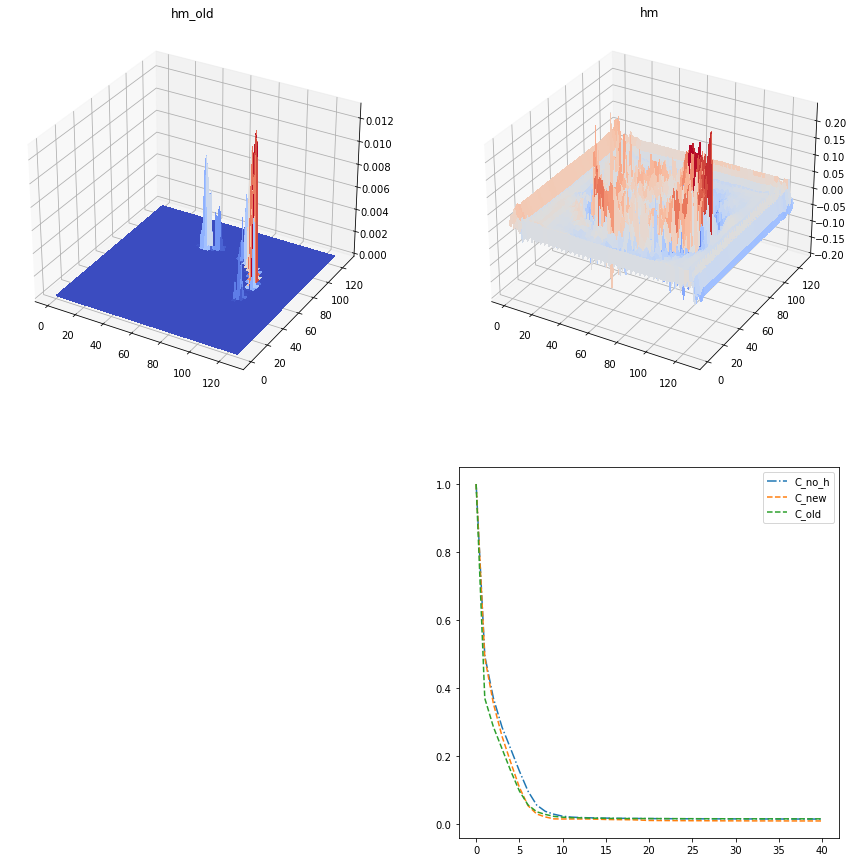

In [11]:
tss = float(tf.reduce_sum((ref_img-diff_dem(ref_img,temp_img,0)[0])**2))
SSDs = SSD/tss
SSDs1 = SSD1/tss

from matplotlib import cm
X = np.arange(0,shape,1)
Y = np.arange(0,shape,1)
Y, X = np.meshgrid(X, Y)
i = np.arange(0,len(SSDs[0]),1)

fig = plt.figure(figsize=(15,15))
u_1 = fig.add_subplot(222,projection='3d')
plt.title('hm')
u_1.plot_surface(X, Y, hmm, cmap=cm.coolwarm,linewidth=0, antialiased=False)

u_2 = fig.add_subplot(221,projection='3d')
plt.title('hm_old')
u_2.plot_surface(X, Y, hms, cmap=cm.coolwarm,linewidth=0, antialiased=False)

'''u_3 = fig.add_subplot(223,projection='3d')
plt.title('h')
u_3.plot_surface(X, Y, h, cmap=cm.coolwarm,linewidth=0, antialiased=False)'''

fig.add_subplot(224)
plt.plot(i, SSDs[0], label = "C_no_h",linestyle="-.")
plt.plot(i, SSDs[1], label = "C_new",linestyle="--")
plt.plot(i, SSDs1[0], label = "C_old",linestyle="--")
#plt.plot(i, SSDs1[1], label = "Cu",linestyle="--")
plt.legend()
plt.show()

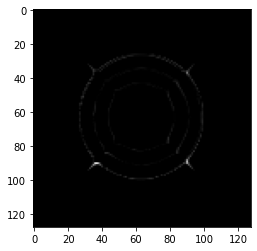

In [12]:
plt.imshow(abs(warped_img_h-warped_img),cmap='gray',vmin=0,vmax=1)

In [13]:
print(np.max(abs(hm)),update_T)
tss = float(tf.reduce_sum((ref_img-diff_dem(ref_img,temp_img,0)[0])**2))
print(tss,SSDs[:,-1]*tss)

0.22631557 50
1408.316650390625 [21.982367  14.1533165]


In [14]:
print('PSNR',cv2.PSNR(np.uint8(ref_img*255),np.uint8(warped_img*255),255))
print('PSNR+h_old',cv2.PSNR(np.uint8(ref_img*255),np.uint8(warped_img_s*255),255))
print('PSNR+h',cv2.PSNR(np.uint8(ref_img*255),np.uint8(warped_img_h*255),255))

PSNR 28.72692114479847
PSNR+h_old 28.54591310887312
PSNR+h 30.635274650159708
